# iCAT Import Data to `render-ws`
---
Overview and interactive walkthrough of how to import image data into `render-ws` via `render-python`.

There are 2 key concepts to keep in mind when importing data to `render-ws`
1. All input data is contained in "tile specifications". So our job is to fill in the tile specification as neatly as possible.
2. Tiles are rendered according to their alpha-numeric tileId. That is, `aaa-tile-00x00` is rendered on top of `zzz-tile-36x48`. In general, we would like to have tiles sorted chronologically such that the tile that was acquired later in time will always appear on top.
3. It is simplest if we import data one stack at a time.

Below is a table summarizing the parameters needed for a [TileSpec](https://github.com/fcollman/render-python/blob/master/renderapi/tilespec.py#L17) object.

| Field    | Type     | Default | Description                                |
| -----    | ----     | ------- | -----------                                |
| tileId   | str      | None    | Unique string specifying a tile's identity |
| z        | float    | None    | z values this tile exists within           |
| width    | int      | None    | Width in pixels of the raw tile            |
| height   | int      | None    | Height in pixels of the raw tile           |
| imageUrl | str      | None    | An image path URI                          |
| maskUrl  | str      | None    | An image path for an alpha mask            |
| minint   | int      | 0       | Pixel intensity value to display as black  |
| maxint   | int      | 65535   | Pixel intensity value to display as white  |
| layout   | `Layout` | None    | a `Layout` object for this tile            |
| tforms   | list     | [ ]     | Transform objects                          |

And because a `TileSpec` requires a `Layout`, below is a table summarizing the parameters needed for a [Layout](https://github.com/fcollman/render-python/blob/master/renderapi/layout.py#L1) object.

| Field     | Type  | Default | Description                                  |
| -----     | ----  | ------- | -----------                                  |
| sectionId | str   | None    | sectionId this tile was taken from           |
| scopeId   | str   | None    | What microscope this came from               |
| cameraId  | str   | None    | Camera this was taken with                   |
| imageRow  | int   | None    | Row from a row,col layout this was taken     |
| imageCol  | int   | None    | Column from a row,col layout this was taken  |
| stageX    | float | None    | X stage coordinates for where this was taken |
| stageY    | float | None    | Y stage coordinates for where this was taken |
| rotation  | float | None    | Angle of camera when this was taken          |
| pixelsize | float | None    | Effective size of pixels                     |

So the game plan will be to build up layouts and tile specifications from metadata and apriori knowledge we have our of our image data. Then we will import the tile specifications into `render-ws` using the appropriate `render-python` method.

## 1 Build Up DataFrames of All Tile Data for Each Stack
---
### 1.0 Import Necessary Packages

In [22]:
import re
from pathlib import Path
from itertools import product
from random import sample
from io import BytesIO

import requests
import numpy as np
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup as Soup
from tqdm import tqdm_notebook
from shapely.geometry import box
import altair as alt
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

from skimage.external.tifffile import TiffFile, imread
from skimage.exposure import histogram

import renderapi
from renderapi.tilespec import TileSpec
from renderapi.layout import Layout
from renderapi.transform import AffineModel as AffineRender

from parse_metadata import parse_metadata

#### Options

In [7]:
pd.set_option('display.max_colwidth', -1)

### 1.1 Infer Stacks and Tiles from Project Directory Tree
Assumes that the project directory structure resembles
```
┌ project
└───┬ S1
    ├───┬ hoechst
    │   ├──── hoechst-00000x00000.tif
    │   ├──── hoechst-00001x00000.tif
    │   ├──── ...
    │   ├──── hoechst-00004x00004.tif
    │   └──── hoechst-00004x00005.tif
    ├───┬ insulin
    │   ├──── insulin-00000x00000.tif
    │   ├──── insulin-00001x00000.tif
    │   ├──── ...
    │   ├──── insulin-00004x00004.tif
    │   └──── insulin-00004x00005.tif
    ├───┬ big_EM
    │   ├──── big_EM-00000x00000.tif
    │   ├──── big_EM-00001x00000.tif
    │   ├──── ...
    │   ├──── big_EM-00004x00004.tif
    │   └──── big_EM-00004x00005.tif
    └───┬ lil_EM
        ├──── lil_EM-00000x00000.tif
        ├──── lil_EM-00001x00000.tif
        ├──── ...
        ├──── lil_EM-00016x00012.tif
        └──── lil_EM-00016x00013.tif
```

following from `iCAT-organize`.

In [8]:
owner = 'rlane'  # replace with your name
project = '20190517_UMCG_RL005'

section_thickness = 80  # nm

In [9]:
project_dir = Path(f'/long_term_storage/{owner}/SECOM/projects/{project}')
stack_dirs = list(project_dir.glob('[!_]*/[!_]*'))
sections = np.unique([stack_dir.parent.name for stack_dir in stack_dirs]).tolist()
stacks = np.unique([stack_dir.name for stack_dir in stack_dirs]).tolist()

out = f"""\
project.... {project}
sections... {sections}
stacks..... {stacks}
"""

print(out)

project.... 20190517_UMCG_RL005
sections... ['S001']
stacks..... ['big_EM', 'hoechst', 'lil_EM']



### 1.3 Create Initial DataFrame for Each Stack Based on Metadata

In [10]:
# Initialize tile data DataFrame
stack_data = pd.DataFrame(columns=['section', 'stack'])

for stack_dir in stack_dirs:
    # Set section and stack
    section = stack_dir.parent.name
    stack = stack_dir.name
    
    # Iterate through tile data
    tile_fns = list(stack_dir.glob('*.tif'))
    for i in tqdm_notebook(range(len(tile_fns))):
        # Parse metadata
        tile_dict = parse_metadata(tile_fns[i], section)
        # Build up DataFrame
        df = pd.DataFrame(tile_dict, index=[i])
        df['section'] = section
        df['stack'] = stack
        stack_data = stack_data.append(df, sort=False)

#### Sample tile data DataFrame

In [11]:
stack_data.groupby('stack').apply(lambda x: x.sample(2))

section    stack    z   width  height  \
stack                                               
big_EM  13   S001    big_EM   1.0  4096.0  4096.0   
        12   S001    big_EM   1.0  4096.0  4096.0   
hoechst 0    S001    hoechst  1.0  2048.0  2048.0   
        8    S001    hoechst  1.0  2048.0  2048.0   
lil_EM  837  S001    lil_EM   1.0  4096.0  4096.0   
        435  S001    lil_EM   1.0  4096.0  4096.0   

                                                                                                            imageUrl  \
stack                                                                                                                  
big_EM  13   file:///long_term_storage/rlane/SECOM/projects/20190517_UMCG_RL005/S001/big_EM/big_EM-00003x00001.tif     
        12   file:///long_term_storage/rlane/SECOM/projects/20190517_UMCG_RL005/S001/big_EM/big_EM-00003x00000.tif     
hoechst 0    file:///long_term_storage/rlane/SECOM/projects/20190517_UMCG_RL005/S001/hoechst/hoechst-00000x00000.tif   
        8    file:///long_term_storage/rlane/SECOM/projects/20190517_UMCG_RL005/S001/hoechst/hoechst-00002x00000.tif   
lil_EM  837  file:///long_term_storage/rlane/SECOM/projects/20190517_UMCG_RL005/S001/lil_EM/lil_EM-00008x00027.tif     
        435  file:///long_term_storage/rlane/SECOM/projects/20190517_UMCG_RL005/S001/lil_EM/lil_EM-00036x00001.tif     

            maskUrl  minint   maxint  \
stack                                  
big_EM  13   None    0.0     65535.0   
        12   None    0.0     65535.0   
hoechst 0    None    0.0     65535.0   
        8    None    0.0     65535.0   
lil_EM  837  None    0.0     65535.0   
        435  None    0.0     65535.0   

                                                         layout  imageRow  \
stack                                                                       
big_EM  13   <renderapi.layout.Layout object at 0x7fd53c202190>  1.0        
        12   <renderapi.layout.Layout object at 0x7fd53c8058d0>  0.0        
hoechst 0    <renderapi.layout.Layout object at 0x7fd53c618910>  0.0        
        8    <renderapi.layout.Layout object at 0x7fd53c6fa9d0>  0.0        
lil_EM  837  <renderapi.layout.Layout object at 0x7fd53c0a1250>  27.0       
        435  <renderapi.layout.Layout object at 0x7fd53c0b25d0>  1.0        

             imageCol      stageX      stageY   pixelsize  \
stack                                                       
big_EM  13   3.0       368.595000  309.102000  36.473647    
        12   3.0       368.361000  510.573000  36.473647    
hoechst 0    0.0      -236.928426  510.799306  109.943517   
        8    2.0       166.522574  510.814306  109.943517   
lil_EM  837  8.0      -127.151000  35.111000   4.841607     
        435  36.0      361.600000  488.184000  4.841607     

                               tileId             acqTime  overlap  
stack                                                               
big_EM  13   big_EM-S001-00003x00001  2019-05-17 16:06:45  12.0     
        12   big_EM-S001-00003x00000  2019-05-17 16:02:40  12.0     
hoechst 0    hoechst-S001-00000x00000 2019-05-17 15:50:16  12.0     
        8    hoechst-S001-00002x00000 2019-05-17 15:58:59  12.0     
lil_EM  837  lil_EM-S001-00008x00027  2019-05-19 00:13:50  12.0     
        435  lil_EM-S001-00036x00001  2019-05-17 18:01:49  12.0

section,S001
stack,
big_EM,16
hoechst,16
lil_EM,1180


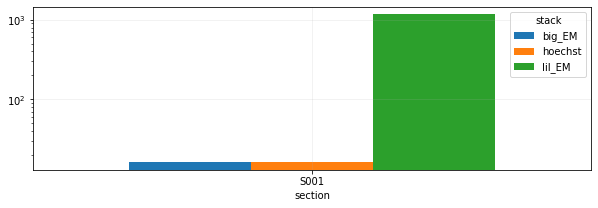

In [12]:
# Make tile count DataFrame for plotting / display purposes
count_data = pd.DataFrame(stack_data.groupby(['section', 'stack'])['tileId'].count())
count_data = count_data.reset_index().pivot('section', 'stack', 'tileId')

# Set up figure
fig, ax = plt.subplots(figsize=(10, 3))
count_data.plot(kind='bar', width=0.95, rot=0, grid=True, logy=True, ax=ax);
ax.grid(alpha=0.2);

# Preview
count_data.T

## 2 Refine DataFrames
---
Although we are able to derive a large portion of the tile specifications from the metadata, there are still several fields in need of updating
* tileId
* stageX
* stageY
* tforms
* minint
* maxint

### 2.1 tileId: Add alphanumeric prefix

In [13]:
def gen_prefix(n=3):
    """Generates a sequence of length `n` characters in alphabetical order
    e.g. [aaa, aab, aac, ..., zzx, zzy, zzz] for n=3
    """
    n = min(n, 4)
    characters = 'abcdefghijklmnopqrstuvwxyz'
    for s in product(characters, repeat=n):
        yield ''.join(s)

In [14]:
tilesets = []
for (stack, z, section), tileset in stack_data.groupby(['stack', 'z', 'section']):
    
    # Sort by acquisition time such that top entry is last acquired
    tileset = tileset.sort_values('acqTime', ascending=False).copy()
    tileset = tileset.reset_index(drop=True).copy()
    
    # Prepend alphanumeric prefix to each tileId
    prefixes = pd.Series(gen_prefix())[:len(tileset)]
    tileset['tileId'] = prefixes + '_' + tileset['tileId']
    tilesets.append(tileset)
    
# Update stack data
stack_data = pd.concat(tilesets)
stack_data.reset_index(drop=True, inplace=True)

# Preview
rs = stack_data['z'].sample(1).iloc[0]
stack_data[stack_data['z'] == rs].groupby('stack').apply(
    lambda x: x.head(5))[['section', 'stack', 'z', 'tileId', 'acqTime']]

section    stack    z                        tileId  \
stack                                                            
big_EM  0   S001    big_EM   1.0  aaa_big_EM-S001-00000x00003    
        1   S001    big_EM   1.0  aab_big_EM-S001-00001x00003    
        2   S001    big_EM   1.0  aac_big_EM-S001-00002x00003    
        3   S001    big_EM   1.0  aad_big_EM-S001-00003x00003    
        4   S001    big_EM   1.0  aae_big_EM-S001-00003x00002    
hoechst 16  S001    hoechst  1.0  aaa_hoechst-S001-00000x00003   
        17  S001    hoechst  1.0  aab_hoechst-S001-00001x00003   
        18  S001    hoechst  1.0  aac_hoechst-S001-00002x00003   
        19  S001    hoechst  1.0  aad_hoechst-S001-00003x00003   
        20  S001    hoechst  1.0  aae_hoechst-S001-00003x00002   
lil_EM  32  S001    lil_EM   1.0  aaa_lil_EM-S001-00000x00033    
        33  S001    lil_EM   1.0  aab_lil_EM-S001-00001x00033    
        34  S001    lil_EM   1.0  aac_lil_EM-S001-00002x00033    
        35  S001    lil_EM   1.0  aad_lil_EM-S001-00003x00033    
        36  S001    lil_EM   1.0  aae_lil_EM-S001-00004x00033    

                       acqTime  
stack                           
big_EM  0  2019-05-17 16:47:37  
        1  2019-05-17 16:43:47  
        2  2019-05-17 16:40:04  
        3  2019-05-17 16:37:06  
        4  2019-05-17 16:32:05  
hoechst 16 2019-05-17 16:47:33  
        17 2019-05-17 16:43:43  
        18 2019-05-17 16:40:00  
        19 2019-05-17 16:37:02  
        20 2019-05-17 16:32:01  
lil_EM  32 2019-05-19 05:51:38  
        33 2019-05-19 05:50:10  
        34 2019-05-19 05:48:42  
        35 2019-05-19 05:47:14  
        36 2019-05-19 05:45:46

### Plot stage coordinates for each layer

section    stack    z                        tileId  \
stack                                                              
big_EM  13    S001    big_EM   1.0  aan_big_EM-S001-00002x00000    
        14    S001    big_EM   1.0  aao_big_EM-S001-00001x00000    
        15    S001    big_EM   1.0  aap_big_EM-S001-00000x00000    
hoechst 29    S001    hoechst  1.0  aan_hoechst-S001-00002x00000   
        30    S001    hoechst  1.0  aao_hoechst-S001-00001x00000   
        31    S001    hoechst  1.0  aap_hoechst-S001-00000x00000   
lil_EM  1209  S001    lil_EM   1.0  bth_lil_EM-S001-00007x00000    
        1210  S001    lil_EM   1.0  bti_lil_EM-S001-00006x00000    
        1211  S001    lil_EM   1.0  btj_lil_EM-S001-00005x00000    

                         acqTime      stageX      stageY  imageCol  imageRow  
stack                                                                         
big_EM  13   2019-05-17 15:59:02  166.603000  510.569000  2.0       0.0       
        14   2019-05-17 15:55:39 -35.060000   510.562000  1.0       0.0       
        15   2019-05-17 15:50:19 -236.843000  510.551000  0.0       0.0       
hoechst 29   2019-05-17 15:58:59  166.522574  510.814306  2.0       0.0       
        30   2019-05-17 15:55:36 -35.140426   510.807306  1.0       0.0       
        31   2019-05-17 15:50:16 -236.928426  510.799306  0.0       0.0       
lil_EM  1209 2019-05-17 17:17:40 -144.395000  505.319000  7.0       0.0       
        1210 2019-05-17 17:15:19 -162.344000  505.337000  6.0       0.0       
        1211 2019-05-17 17:13:51 -179.408000  505.348000  5.0       0.0

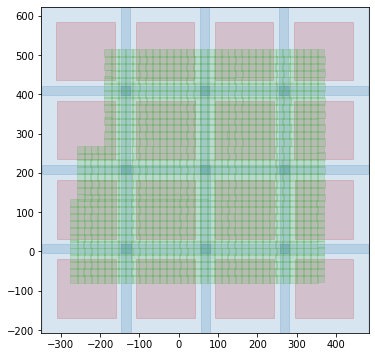

In [15]:
for (z, section), layer in stack_data.groupby(['z', 'section']):
    
    # Set up figure
    fig, ax = plt.subplots(figsize=(6, 6))
    colors = sns.color_palette('Set1', n_colors=len(stacks))
    boxes = []
    
    # Plot stage coordinates of each layer
    for c, (channel, tileset) in enumerate(layer.groupby('stack')):
        
        for i, tile in tileset.iterrows():
            
            # Create `shapely.box`
            dx = tile['width']/2 * tile['pixelsize']/1e3
            dy = tile['height']/2 * tile['pixelsize']/1e3
            minx, maxx = (tile['stageX'] - dx, tile['stageX'] + dx)
            miny, maxy = (tile['stageY'] - dy, tile['stageY'] + dy)
            b = box(minx, miny, maxx, maxy)
            boxes.append(b)
            
            # Plot `shapely.box` as patch
            xy = np.array(b.exterior.xy).T
            p = Polygon(xy, color=colors[c], alpha=0.2)
            ax.add_patch(p)
            
    # Axis aesthetics
    bounds = np.swapaxes([b.exterior.xy for b in boxes], 1, 2).reshape(-1, 2)
    ax.set_xlim(bounds[:, 0].min(), bounds[:, 0].max())
    ax.set_ylim(bounds[:, 1].min(), bounds[:, 1].max())
    ax.set_aspect('equal')
    
# Preview
rs = stack_data['z'].sample(1).iloc[0]
stack_data[stack_data['z'] == rs].groupby('stack').apply(
    lambda x: x.tail(3))[['section', 'stack', 'z', 'tileId', 'acqTime', 'stageX', 'stageY', 'imageCol', 'imageRow']]

### 2.2 tforms: Determine Affine Transformation
For montaging, it is best to have the image tiles in *pixel space*. So we postpone applying transforms derived from the metadata until after montaging. But it is still good/necessary to apply transformations in the form of translations so that we have tiles in the right place with high fidelity for montaging.

There are 2 reasonable ways to apply translation
1. Derive translations from stage positions
2. Derive translations from tile row and column index together with height, width, and overlap information

But (1) is more reasonable than (2), so we go with (1). The first step is to normalize the tile grid such that leftmost tile is at $x=0$ and the bottommost tile is at $y=0$. Then we convert the coordinates into *pixel space* by dividing the stage position by the pixel size. Both of these operations are done on a per tileset basis.

In [16]:
tilesets = []
for (stack, z, section), tileset in stack_data.groupby(['stack', 'z', 'section']):
    
    # Normalize stage coordinates to (0, 0)
    x_translation = tileset['stageX'] - tileset['stageX'].min()
    y_translation = tileset['stageY'] - tileset['stageY'].min()

    # Divide by pixelsize and flip y axis
    x_translation =  x_translation / (tileset['pixelsize']/1e3)
    y_translation = -y_translation / (tileset['pixelsize']/1e3)

    # Shift y translation up so that it's all positivo
    y_translation -= y_translation.min()

    # Translate translations into `AffineRender`
    tileset = tileset.copy()  # to prevent SettingWithCopyWarning
    tileset['tforms'] = [[AffineRender(B0=x, B1=y)] for x, y in zip(x_translation, y_translation)]
    tilesets.append(tileset)

# Update stack data
stack_data = pd.concat(tilesets)

#### Show transforms
Plot tries to mimic `render` output in "pixel space"

<table>
    <tr>
        <th>Axis</th>
        <th>Direction</th>
    </tr>
    <tr>
        <td>$+x$</td>
        <td>$\rightarrow$</td>
    </tr>
    <tr>
        <td>$+y$</td>
        <td>$\downarrow$</td>
    </tr>
</table>

In [17]:
# Make transform DataFrame for plotting / display purposes
transform_cols = ['stack', 'z', 'section', 'tileId', 'acqTime', 'stageX', 'stageY', 'imageCol', 'imageRow', 'tforms']
transform_data = stack_data.loc[:, transform_cols].copy().reset_index(drop=True)
transform_data['translationX'] = [tforms[0].B0 for tforms in transform_data['tforms']]
transform_data['translationY'] = [tforms[0].B1 for tforms in transform_data['tforms']]
transform_data.drop(columns=['tforms'], inplace=True)

rs = stack_data['z'].sample(1).iloc[0]
transform_data[transform_data['z'] == rs].groupby(
    'stack').apply(
    lambda x: x.head(5))

stack    z section                        tileId  \
stack                                                            
big_EM  0   big_EM   1.0  S001    aaa_big_EM-S001-00000x00003    
        1   big_EM   1.0  S001    aab_big_EM-S001-00001x00003    
        2   big_EM   1.0  S001    aac_big_EM-S001-00002x00003    
        3   big_EM   1.0  S001    aad_big_EM-S001-00003x00003    
        4   big_EM   1.0  S001    aae_big_EM-S001-00003x00002    
hoechst 16  hoechst  1.0  S001    aaa_hoechst-S001-00000x00003   
        17  hoechst  1.0  S001    aab_hoechst-S001-00001x00003   
        18  hoechst  1.0  S001    aac_hoechst-S001-00002x00003   
        19  hoechst  1.0  S001    aad_hoechst-S001-00003x00003   
        20  hoechst  1.0  S001    aae_hoechst-S001-00003x00002   
lil_EM  32  lil_EM   1.0  S001    aaa_lil_EM-S001-00000x00033    
        33  lil_EM   1.0  S001    aab_lil_EM-S001-00001x00033    
        34  lil_EM   1.0  S001    aac_lil_EM-S001-00002x00033    
        35  lil_EM   1.0  S001    aad_lil_EM-S001-00003x00033    
        36  lil_EM   1.0  S001    aae_lil_EM-S001-00004x00033    

                       acqTime      stageX      stageY  imageCol  imageRow  \
stack                                                                        
big_EM  0  2019-05-17 16:47:37 -234.734000 -94.150000   0.0       3.0        
        1  2019-05-17 16:43:47 -33.215000  -94.141000   1.0       3.0        
        2  2019-05-17 16:40:04  168.302000 -94.127000   2.0       3.0        
        3  2019-05-17 16:37:06  369.807000 -94.115000   3.0       3.0        
        4  2019-05-17 16:32:05  369.691000  107.433000  3.0       2.0        
hoechst 16 2019-05-17 16:47:33 -234.734000 -94.150000   0.0       3.0        
        17 2019-05-17 16:43:43 -33.215000  -94.141000   1.0       3.0        
        18 2019-05-17 16:40:00  168.639042 -94.005655   2.0       3.0        
        19 2019-05-17 16:37:02  370.144042 -93.993655   3.0       3.0        
        20 2019-05-17 16:32:01  370.552205  107.986578  3.0       2.0        
lil_EM  32 2019-05-19 05:51:38 -266.713000 -69.451000   0.0       33.0       
        33 2019-05-19 05:50:10 -249.204000 -69.460000   1.0       33.0       
        34 2019-05-19 05:48:42 -231.758000 -69.459000   2.0       33.0       
        35 2019-05-19 05:47:14 -214.302000 -69.463000   3.0       33.0       
        36 2019-05-19 05:45:46 -196.897000 -69.467000   4.0       33.0       

            translationX   translationY  
stack                                    
big_EM  0   57.822570     16579.723944   
        1   5582.880141   16579.477190   
        2   11107.882877  16579.093351   
        3   16632.556609  16578.764347   
        4   16629.376231  11052.911681   
hoechst 16  19.886899     5502.537337    
        17  1846.144689   5502.455775    
        18  3675.438787   5501.229219    
        19  5501.569702   5501.120470    
        20  5505.659728   3670.552641    
lil_EM  32  85.302250     118720.697627  
        33  3701.663265   118722.556514  
        34  7305.012071   118722.349971  
        35  10910.426308  118723.176143  
        36  14505.306853  118724.002315

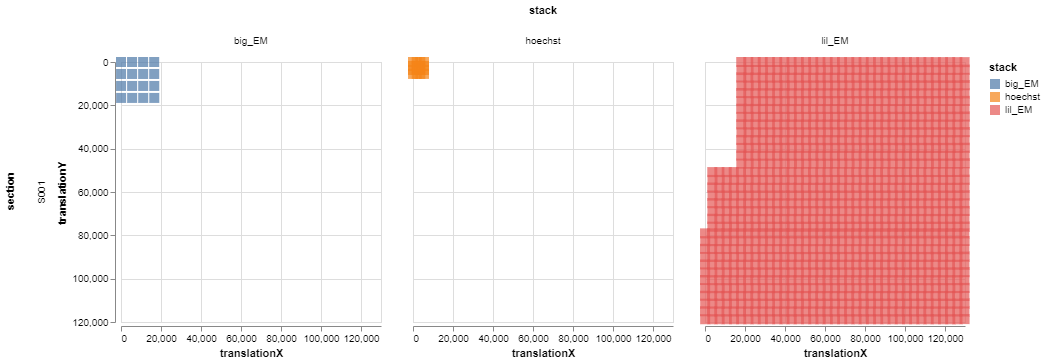

In [18]:
# Set axis limits
domainY = [transform_data['translationY'].max(),
           transform_data['translationY'].min()]

alt.Chart(transform_data).mark_point(filled=True).encode(
    x=alt.X('translationX:Q'),
    y=alt.Y('translationY:Q', scale=alt.Scale(domain=domainY)),
    color='stack:N',
    shape=alt.ShapeValue('square'),
    size=alt.SizeValue(100),
    column='stack:N',
    row='section:N',
    tooltip=transform_data.columns.tolist()
).properties(
    width=260,
    height=260
)

### 2.4 minint, maxint: Determine Intensity Range
The choice for minimum and maximum intensity levels has implications for both SIFT point match finding and the visual/aesthetic side of things. At present, the best choice for EM images appears to be symmetric clipping at ~0.1% of the histogram applied to each image (after applying local normalized contrast filtering).

In [19]:
def get_intensity_levels_EM(image, pct=0.0):
    """Symmetric clipping about image mean"""
    p1 = np.percentile(image, pct)
    p2 = image.mean() + (image.mean() - p1)
    return (int(p1), int(p2))

def get_intensity_levels_FM(image, pct=0.39):
    """Standard intensity clipping"""
    p1, p2 = np.percentile(image, (pct, 100-pct))
    return (int(p1), int(p2))

In [24]:
# Add `avgint` column to stack data
stack_data['avgint'] = None

for (stack, z, section), tileset in stack_data.groupby(['stack', 'z', 'section']):
    
    # Loop through each tileset
    for i, tile in tqdm_notebook(tileset.iterrows(), total=len(tileset)):
        
        if 'EM' in stack:
            p1, p2 = (0, 65535)
            
        else:  # FM channel
            # Read image
            fp = Path(tile['imageUrl'].split('://')[-1])
            image = imread(fp.as_posix())
            
            # Determine intensity levels
            p1, p2 = get_intensity_levels_FM(image)
        
#         # Read image
#         fp = Path(tile['imageUrl'].split('://')[-1])
#         image = imread(fp.as_posix())
        
#         # Determine intensity levels
#         if 'EM' in stack:
#             p1, p2 = get_intensity_levels_EM(image)
#         else:  # FM channel
#             p1, p2 = get_intensity_levels_FM(image)
        
        # Update stack data
        stack_data.loc[i, 'minint'] = p1
        stack_data.loc[i, 'maxint'] = p2
        stack_data.loc[i, 'avgint'] = image.mean()
        
# Preview
levels_cols = ['stack', 'z', 'section', 'tileId', 'acqTime', 'minint', 'maxint', 'avgint']
levels_data = stack_data.loc[:, levels_cols].copy()

rs = stack_data['z'].sample(1).iloc[0]
levels_data[levels_data['z'] == rs].groupby(
    'stack').apply(
    lambda x: x.head(5))

stack    z section                        tileId  \
stack                                                            
big_EM  0   big_EM   1.0  S001    aaa_big_EM-S001-00000x00003    
        1   big_EM   1.0  S001    aab_big_EM-S001-00001x00003    
        2   big_EM   1.0  S001    aac_big_EM-S001-00002x00003    
        3   big_EM   1.0  S001    aad_big_EM-S001-00003x00003    
        4   big_EM   1.0  S001    aae_big_EM-S001-00003x00002    
hoechst 16  hoechst  1.0  S001    aaa_hoechst-S001-00000x00003   
        17  hoechst  1.0  S001    aab_hoechst-S001-00001x00003   
        18  hoechst  1.0  S001    aac_hoechst-S001-00002x00003   
        19  hoechst  1.0  S001    aad_hoechst-S001-00003x00003   
        20  hoechst  1.0  S001    aae_hoechst-S001-00003x00002   
lil_EM  32  lil_EM   1.0  S001    aaa_lil_EM-S001-00000x00033    
        33  lil_EM   1.0  S001    aab_lil_EM-S001-00001x00033    
        34  lil_EM   1.0  S001    aac_lil_EM-S001-00002x00033    
        35  lil_EM   1.0  S001    aad_lil_EM-S001-00003x00033    
        36  lil_EM   1.0  S001    aae_lil_EM-S001-00004x00033    

                       acqTime  minint   maxint   avgint  
stack                                                     
big_EM  0  2019-05-17 16:47:37  0.0     65535.0  38870.3  
        1  2019-05-17 16:43:47  0.0     65535.0  38870.3  
        2  2019-05-17 16:40:04  0.0     65535.0  38870.3  
        3  2019-05-17 16:37:06  0.0     65535.0  38870.3  
        4  2019-05-17 16:32:05  0.0     65535.0  38870.3  
hoechst 16 2019-05-17 16:47:33  1074.0  6862.0   2505.49  
        17 2019-05-17 16:43:43  1071.0  6300.0   2750.35  
        18 2019-05-17 16:40:00  1067.0  5408.0   2522.84  
        19 2019-05-17 16:37:02  1091.0  3090.0   1860.74  
        20 2019-05-17 16:32:01  1076.0  4054.0   2133.91  
lil_EM  32 2019-05-19 05:51:38  0.0     65535.0  1916.43  
        33 2019-05-19 05:50:10  0.0     65535.0  1916.43  
        34 2019-05-19 05:48:42  0.0     65535.0  1916.43  
        35 2019-05-19 05:47:14  0.0     65535.0  1916.43  
        36 2019-05-19 05:45:46  0.0     65535.0  1916.43

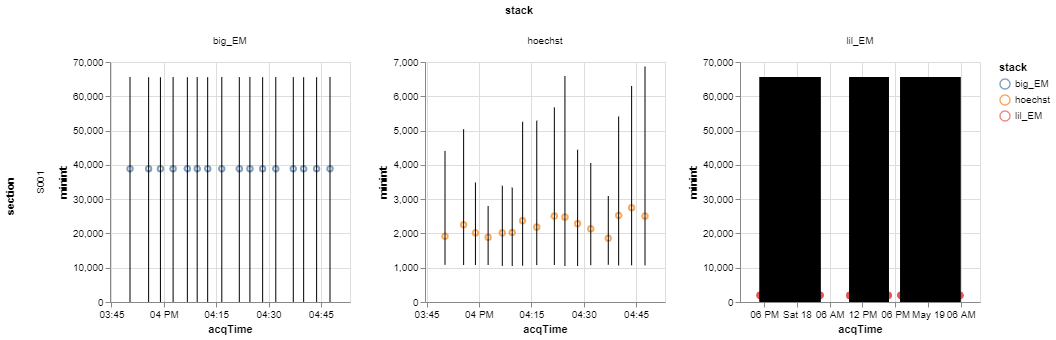

In [25]:
points = alt.Chart(levels_data).mark_point().encode(
    x=alt.X('acqTime:T', scale=alt.Scale(padding=20)),
    y='avgint:Q',
    color='stack:N',
).properties(
    width=240,
    height=240
)

errors = alt.Chart(levels_data).mark_errorbar().encode(
    x='acqTime',
    y='minint:Q',
    y2='maxint:Q',
)

alt.layer(points, errors, data=levels_data).facet(
    column='stack:N',
    row='section:N'
).resolve_scale(
    x='independent',
    y='independent'
)

In [40]:
minint_hoechst, maxint_hoechst = levels_data.loc[levels_data['stack'] == 'hoechst', ['minint', 'maxint']].median(axis=0)
minint_hoechst, maxint_hoechst

(1075.0, 4738.5)

In [41]:
stack_data.loc[stack_data['stack'] == 'hoechst', ['minint', 'maxint']] = minint_hoechst, maxint_hoechst
stack_data.loc[stack_data['stack'] == 'hoechst', ['minint', 'maxint']]

,minint,maxint
16,1075.0,4738.5
17,1075.0,4738.5
18,1075.0,4738.5
19,1075.0,4738.5
20,1075.0,4738.5
21,1075.0,4738.5
22,1075.0,4738.5
23,1075.0,4738.5
24,1075.0,4738.5
25,1075.0,4738.5


## 3 Import to Render
---
Up until now, we have yet to involve `render-ws` in any way. We have only worked on building up a table of data about our image stacks and tiles. Now that we have such a table, importing this data into `render` is easy-peasy.

### 3.1 Initialize render

In [42]:
# Create a renderapi.connect.Render object
render_connect_params = {
    'host': 'sonic',
    'port': 8080,
    'owner': owner,
    'project': project,
    'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
    'memGB': '2G'
}
render = renderapi.connect(**render_connect_params)

### 3.2 Create stacks and import tile specifications

In [43]:
for stack, tiles in tqdm_notebook(stack_data.groupby('stack'), total=len(stacks)):
    
    # Create `TileSpec`s
    tile_specs = []
    for i, tile in tiles.iterrows():
        ts = TileSpec(**tile.to_dict())
        tile_specs.append(ts)
        
    # Set stack resolution
    # TODO: make this more robust - pixelsize should really be set on a per tile basis
    #       but as of now (in `render-ws` NOT `render-python`) it is a stack parameter
    Rx = tiles['pixelsize'].iloc[0]
    Ry = tiles['pixelsize'].iloc[0]
    Rz = section_thickness
    
    # Create stacks
    renderapi.stack.create_stack(stack,
                                 stackResolutionX=Rx,
                                 stackResolutionY=Ry,
                                 stackResolutionZ=Rz,
                                 render=render)
    
    # Import TileSpecs to render
    renderapi.client.import_tilespecs(stack,
                                      tile_specs,
                                      render=render)
    
    # Set stack state to complete
    renderapi.stack.set_stack_state(stack, 'COMPLETE', render=render)

## 4 Inspect stacks
---

\*\****MAY TAKE AN EXTREMELY LONG TIME*** \**

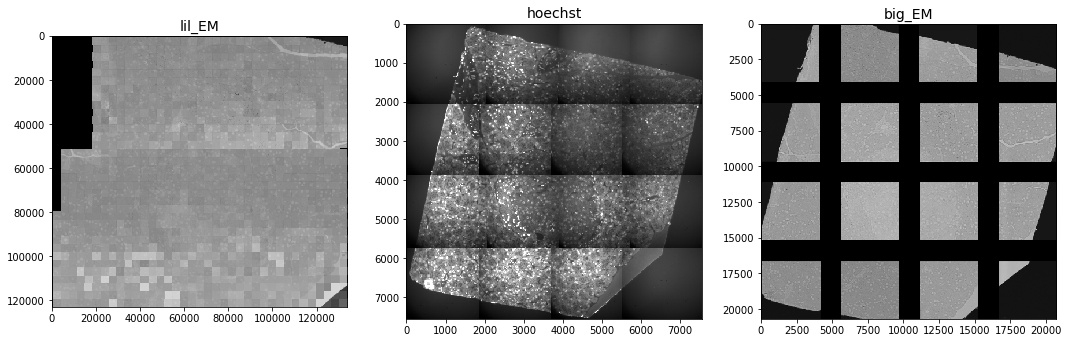

In [44]:
stacks = renderapi.render.get_stacks_by_owner_project(render=render)

for (z, section), layer in tqdm_notebook(stack_data.groupby(['z', 'section']), total=len(sections)):
    
    # Set up figure
    ncols = len(stacks)
    fig, axes = plt.subplots(ncols=ncols, figsize=(6*ncols, 6))
    
    for c, stack in tqdm_notebook(enumerate(stacks), total=len(stacks)):
        
        # Get section bounds
        bounds = renderapi.stack.get_bounds_from_z(stack=stack,
                                                   z=z,
                                                   render=render)
        
        # Fetch section image per stack
        scale = 512 / (bounds['maxX'] - bounds['minX'])
        image = renderapi.image.get_section_image(stack=stack,
                                                  z=z,
                                                  scale=scale,
                                                  filter=False,
                                                  render=render)
        
        # Plot image
        extent = [bounds[k] for k in ['minX', 'maxX', 'minY', 'maxY']]  # [left, right, bottom, top]
        axes[c].imshow(image, extent=extent, origin='lower')
        
        # Axis aesthetics
        axes[c].invert_yaxis()
        if z == stack_data['z'].min():
            axes[c].set_title(f'{stack}', fontsize=14)